# Neural Network Mortgage Prepayment Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import time
import imp
import os
import os, os.path
import datetime as dt
import dateutil.parser as dp
import dill
import datetime as dt

%matplotlib inline

## Load data from pkl file

In [2]:
df = pd.read_pickle("../jumbos_30yr.pkl")

In [7]:
df['Seasonality'] = df['asofdate'].apply(lambda x: int(str(x)[-2:]))

### Make sure all the fields (except cusip and poolsno) are numerical and there are no NAs

In [8]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225138 entries, 0 to 225137
Data columns (total 111 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   poolno              225138 non-null  object 
 1   asofdate            225138 non-null  int64  
 2   cusip               225138 non-null  object 
 3   spread              225138 non-null  float64
 4   SMM                 225138 non-null  float64
 5   DayCount            225138 non-null  int64  
 6   OBal                225138 non-null  int64  
 7   CBal                225138 non-null  float64
 8   factor              225138 non-null  float64
 9   Coupon              225138 non-null  float64
 10  Wac                 225138 non-null  float64
 11  Wam                 225138 non-null  int64  
 12  Age                 225138 non-null  int64  
 13  aols                225138 non-null  float64
 14  waols               225138 non-null  float64
 15  ONLoans             225138 non-nu

In [9]:
# df.to_pickle('../conv_30yr.pkl')

In [10]:
print('df.shape = ', df.shape)

df.shape =  (225138, 111)


## Model features selection and defining train/test split

* In this section we select which features (columns) are to be used in the model and define a test-train split. 

In [11]:
dummies = pd.get_dummies(df['Seasonality'],drop_first=True)
df = df.drop('Seasonality',axis=1)
df = pd.concat([df,dummies],axis=1)

print(f'df.shape = {df.shape}')

df.shape = (225138, 121)


In [305]:
list(dummies.columns)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [306]:
model_columns = ['asofdate',
                 'SMM',
                 'spread',
                 'DayCount','factor',
                 'Wac','Wam','Age','aols','waols','CSato',
                 'oltv','cltv','ocltv','ccltv',
                 'fico',
                 '%CashWindow','%Majors',
                 'PurpPct_purchase','PurpPct_refi',
                 'PctChannel_Broker','PctChannel_Corr','PctChannel_Retail',
                 'OccPct_investor','OccPct_owner','PropUnitsPct_2-4',
                
                 # features showing geographical composition of a pool
                 'StatePct_AK','StatePct_AL','StatePct_AR','StatePct_AZ','StatePct_CA','StatePct_CO','StatePct_CT',
                 'StatePct_DC','StatePct_DE','StatePct_FL','StatePct_GA','StatePct_GU','StatePct_HI','StatePct_IA',
                 'StatePct_ID','StatePct_IL','StatePct_IN','StatePct_KS','StatePct_KY','StatePct_LA','StatePct_MA',
                 'StatePct_MD','StatePct_ME','StatePct_MI','StatePct_MN','StatePct_MO','StatePct_MS','StatePct_MT',
                 'StatePct_NC','StatePct_ND','StatePct_NE','StatePct_NH','StatePct_NJ','StatePct_NM','StatePct_NV',
                 'StatePct_NY','StatePct_OH','StatePct_OK','StatePct_OR','StatePct_PA','StatePct_PR','StatePct_RI',
                 'StatePct_SC','StatePct_SD','StatePct_TN','StatePct_TX','StatePct_UT','StatePct_VA','StatePct_VI',
                 'StatePct_VT','StatePct_WA','StatePct_WI','StatePct_WV','StatePct_WY',
                 
                 # features showing originator composition of a pool
                 'SellerPct_AMRHT','SellerPct_ALS','SellerPct_CAFULL','SellerPct_CNTL','SellerPct_CITIZ',
                 'SellerPct_53','SellerPct_FIR','SellerPct_FRDOM','SellerPct_GUILD','SellerPct_CHASE',
                 'SellerPct_LLSL','SellerPct_MATRX','SellerPct_NCM','SellerPct_NATIONST','SellerPct_NRESM',
                 'SellerPct_PNYMAC','SellerPct_PILOSI','SellerPct_QUICK','SellerPct_REG','SellerPct_RMSC',
                 'SellerPct_UNSHFI','SellerPct_WFHM'
                ] + list(dummies.columns)

In [369]:
cnloans = 250

dfm = df[df['cnloans'] >= cnloans][model_columns]

print(f'dfm.shape = {dfm.shape}')

dfm.shape = (10812, 113)


In [308]:
data_cutoff = 202010

dfm_train = dfm[dfm['asofdate'] <  data_cutoff]
dfm_test  = dfm[dfm['asofdate'] >= data_cutoff]

X_train = dfm_train.drop(['SMM','asofdate'],axis=1).values
y_train = dfm_train['SMM'].values

X_test = dfm_test.drop(['SMM','asofdate'],axis=1).values
y_test = dfm_test['SMM'].values

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print('\n')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (10710, 111)
y_train.shape = (10710,)


X_test.shape  = (102, 111)
y_test.shape  = (102,)


## FF neural-network mortgage prepayment model

* In this section we fit the model to train data

In [309]:
# scale train/test data because buiding a neural net
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [310]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout

In [311]:
model = Sequential()

model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.4))

#output layer
model.add(Dense(1, activation='relu')) # no activation means linear activation a(x)=x

model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer='rmsprop', loss='mse')

In [312]:
model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test,y_test),
          #batch_size=4*1024,
          epochs=500)

Train on 10710 samples, validate on 102 samples
Epoch 1/500
10710/10710 [==============================] - 2s 172us/sample - loss: 5.0086 - val_loss: 24.9360
Epoch 2/500
10710/10710 [==============================] - 1s 91us/sample - loss: 3.6172 - val_loss: 19.3982
Epoch 3/500
10710/10710 [==============================] - 1s 88us/sample - loss: 3.2418 - val_loss: 19.6999
Epoch 4/500
10710/10710 [==============================] - 1s 88us/sample - loss: 2.8724 - val_loss: 17.0301
Epoch 5/500
10710/10710 [==============================] - 1s 88us/sample - loss: 2.5716 - val_loss: 24.6282
Epoch 6/500
10710/10710 [==============================] - 1s 90us/sample - loss: 2.4346 - val_loss: 17.8777
Epoch 7/500
10710/10710 [==============================] - 1s 89us/sample - loss: 2.4006 - val_loss: 10.4491
Epoch 8/500
10710/10710 [==============================] - 1s 87us/sample - loss: 2.4036 - val_loss: 14.1038
Epoch 9/500
10710/10710 [==============================] - 1s 88us/sample - los

10710/10710 [==============================] - 1s 86us/sample - loss: 1.4714 - val_loss: 9.5110
Epoch 76/500
10710/10710 [==============================] - 1s 85us/sample - loss: 1.4626 - val_loss: 10.6785
Epoch 77/500
10710/10710 [==============================] - 1s 86us/sample - loss: 1.4511 - val_loss: 8.0711
Epoch 78/500
10710/10710 [==============================] - 1s 87us/sample - loss: 1.4603 - val_loss: 7.8663
Epoch 79/500
10710/10710 [==============================] - 1s 88us/sample - loss: 1.3964 - val_loss: 8.5328
Epoch 80/500
10710/10710 [==============================] - 1s 87us/sample - loss: 1.4990 - val_loss: 7.7347
Epoch 81/500
10710/10710 [==============================] - 1s 87us/sample - loss: 1.4379 - val_loss: 8.9029
Epoch 82/500
10710/10710 [==============================] - 1s 87us/sample - loss: 1.4544 - val_loss: 10.0313
Epoch 83/500
10710/10710 [==============================] - 1s 85us/sample - loss: 1.4203 - val_loss: 9.3798
Epoch 84/500
10710/10710 [====

10710/10710 [==============================] - 1s 96us/sample - loss: 1.3581 - val_loss: 8.6366
Epoch 150/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.2606 - val_loss: 6.6887
Epoch 151/500
10710/10710 [==============================] - 1s 95us/sample - loss: 1.3574 - val_loss: 9.8992
Epoch 152/500
10710/10710 [==============================] - 1s 99us/sample - loss: 1.3243 - val_loss: 7.4705
Epoch 153/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.2913 - val_loss: 9.6721
Epoch 154/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.3319 - val_loss: 7.8023
Epoch 155/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.3561 - val_loss: 8.5334
Epoch 156/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.3694 - val_loss: 10.2291
Epoch 157/500
10710/10710 [==============================] - 1s 95us/sample - loss: 1.3213 - val_loss: 9.5142
Epoch 158/500
10710/107

10710/10710 [==============================] - 1s 97us/sample - loss: 1.2388 - val_loss: 8.7971
Epoch 224/500
10710/10710 [==============================] - 1s 98us/sample - loss: 1.2376 - val_loss: 8.9050
Epoch 225/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.3015 - val_loss: 8.2244
Epoch 226/500
10710/10710 [==============================] - 1s 100us/sample - loss: 1.2723 - val_loss: 8.5178
Epoch 227/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.3066 - val_loss: 7.5024
Epoch 228/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.3411 - val_loss: 8.4231
Epoch 229/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.2112 - val_loss: 6.6459
Epoch 230/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.2963 - val_loss: 8.2214
Epoch 231/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.2798 - val_loss: 7.4482
Epoch 232/500
10710/107

10710/10710 [==============================] - 1s 96us/sample - loss: 1.1745 - val_loss: 7.9754
Epoch 298/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.1959 - val_loss: 7.8017
Epoch 299/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.2878 - val_loss: 9.0914
Epoch 300/500
10710/10710 [==============================] - 1s 100us/sample - loss: 1.2920 - val_loss: 7.2758
Epoch 301/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.2237 - val_loss: 9.3020
Epoch 302/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.2439 - val_loss: 8.1051
Epoch 303/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.2401 - val_loss: 7.8883
Epoch 304/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.2387 - val_loss: 9.6591
Epoch 305/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.2548 - val_loss: 8.4429
Epoch 306/500
10710/107

10710/10710 [==============================] - 1s 96us/sample - loss: 1.2389 - val_loss: 7.6650
Epoch 372/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.2299 - val_loss: 8.6448
Epoch 373/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.2496 - val_loss: 6.9170
Epoch 374/500
10710/10710 [==============================] - 1s 98us/sample - loss: 1.2318 - val_loss: 9.5587
Epoch 375/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.2125 - val_loss: 7.8459
Epoch 376/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.2623 - val_loss: 8.7605
Epoch 377/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.2164 - val_loss: 8.5071
Epoch 378/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.2411 - val_loss: 7.0618
Epoch 379/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.2425 - val_loss: 8.7857
Epoch 380/500
10710/1071

10710/10710 [==============================] - 1s 97us/sample - loss: 1.1684 - val_loss: 8.0889
Epoch 446/500
10710/10710 [==============================] - 1s 96us/sample - loss: 1.2112 - val_loss: 9.6029
Epoch 447/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.1841 - val_loss: 7.9479
Epoch 448/500
10710/10710 [==============================] - 1s 99us/sample - loss: 1.1760 - val_loss: 7.8951
Epoch 449/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.2052 - val_loss: 8.7189
Epoch 450/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.2540 - val_loss: 8.2920
Epoch 451/500
10710/10710 [==============================] - 1s 98us/sample - loss: 1.2131 - val_loss: 8.5056
Epoch 452/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.2296 - val_loss: 9.7006
Epoch 453/500
10710/10710 [==============================] - 1s 97us/sample - loss: 1.2951 - val_loss: 8.8967
Epoch 454/500
10710/1071

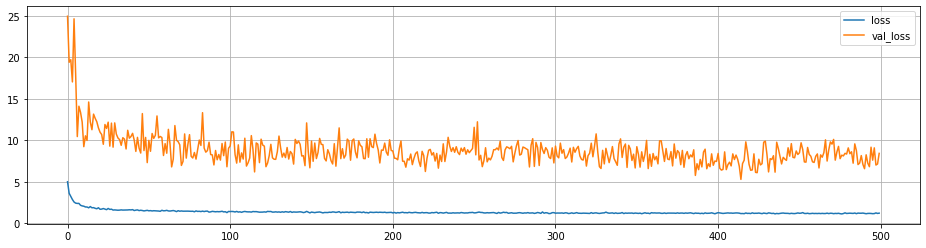

In [313]:
losses = pd.DataFrame(model.history.history)

losses.plot(figsize=(16,4),grid=True)

## Model Evaluation and Validation

* to be updated

### Validation reports

In [345]:
def valReport(dframe,graphTitle='',lcoup=2.5,hcoup=5,fsize=(24,24)):

    ppm_table = dframe[['CBal','model SMM x CBal','SMM x CBal','Coupon','ppmdate']].groupby(['Coupon','ppmdate']).sum()

    ppm_table['SMM'] = ppm_table['SMM x CBal']/ppm_table['CBal']
    ppm_table['CPR'] = 100*(1-(1-ppm_table['SMM']/100)**12)

    ppm_table['model SMM'] = ppm_table['model SMM x CBal']/ppm_table['CBal']
    ppm_table['model CPR'] = 100*(1-(1-ppm_table['model SMM']/100)**12)
    
    fig = plt.figure(figsize=fsize)
    
    plt.axis('off')
    
    plt.title(graphTitle)

    numOfsubgraphs = int((hcoup-lcoup)*2 + 1)

    for i in range(numOfsubgraphs):
        ax = fig.add_subplot(numOfsubgraphs,1,i+1)
        coupon = lcoup + i*0.5
        if ('CPR',coupon) in ppm_table.unstack(level=0).columns:
            ppm_table.unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].plot(ax=ax,grid=True)
            ax.legend()

In [315]:
def rmse_by_coupon(dframe,lcoup=2.5,hcoup=5,col_name='RMSE (CPR)'):
    
    ppm_table = dframe[['CBal','model SMM x CBal','SMM x CBal','Coupon','ppmdate']].groupby(['Coupon','ppmdate']).sum()

    ppm_table['SMM'] = ppm_table['SMM x CBal']/ppm_table['CBal']
    ppm_table['CPR'] = 100*(1-(1-ppm_table['SMM']/100)**12)

    ppm_table['model SMM'] = ppm_table['model SMM x CBal']/ppm_table['CBal']
    ppm_table['model CPR'] = 100*(1-(1-ppm_table['model SMM']/100)**12)
    
    RMSE_by_coupon = dict()
    
    for i in range(int((hcoup-lcoup)*2 + 1)):
        coupon = lcoup + i*0.5
        if ('CPR',coupon) in ppm_table.unstack(level=0).columns:
            act_vs_pred = ppm_table.unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].dropna()
            RMSE_by_coupon[coupon] = np.sqrt(mean_squared_error(act_vs_pred[('CPR',coupon)],act_vs_pred[('model CPR'),coupon]))
            
    RMSE_by_coupon = pd.DataFrame({col_name:list(RMSE_by_coupon.values())},index=RMSE_by_coupon.keys())
    RMSE_by_coupon.index.name = 'Coupon'
    
    return RMSE_by_coupon    

### Validation of a neural-network model on a pool by pool basis.

* to be updated

In [316]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

test_predictions = model.predict(X_test)
print(f'(test set) mean absolute error       = {np.round(mean_absolute_error(y_test,test_predictions),4)}')
print(f'(test set) mean sq root sq error     = {np.round(np.sqrt(mean_squared_error(y_test,test_predictions)),4)}')
print(f'(test set) explained variance score  = {np.round(explained_variance_score(y_test,test_predictions),4)}')
print('\n')
train_predictions = model.predict(X_train)
print(f'(train set) mean absolute error      = {np.round(mean_absolute_error(y_train,train_predictions),4)}')
print(f'(train set) mean sq root sq error    = {np.round(np.sqrt(mean_squared_error(y_train,train_predictions)),4)}')
print(f'(train set) explained variance score = {np.round(explained_variance_score(y_train,train_predictions),4)}')

(test set) mean absolute error       = 2.3191
(test set) mean sq root sq error     = 2.9024
(test set) explained variance score  = 0.8011


(train set) mean absolute error      = 0.52
(train set) mean sq root sq error    = 0.7315
(train set) explained variance score = 0.9022


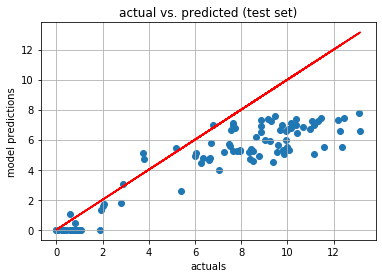

In [317]:
plt.scatter(y_test,test_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (test set)')
plt.plot(y_test,y_test,'r'); plt.grid()

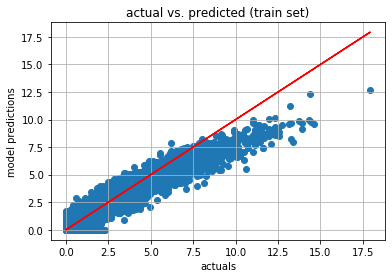

In [318]:
plt.scatter(y_train,train_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (train set)')
plt.plot(y_train,y_train,'r'); plt.grid()

In [319]:
# df[(df['SMM'] - df['model SMM'] > 5) & (df['cnloans'] > 500)][['cusip','Wac','spread','Age','asofdate','cnloans','SMM','model SMM']].head(50)

### Validation of a neural network model on large populations of pools/loans

* Here we examine model performance on large populations of loans

In [320]:
df['model SMM'] = model.predict(scaler.transform(df[model_columns].drop(['SMM','asofdate'],axis=1)))

In [321]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

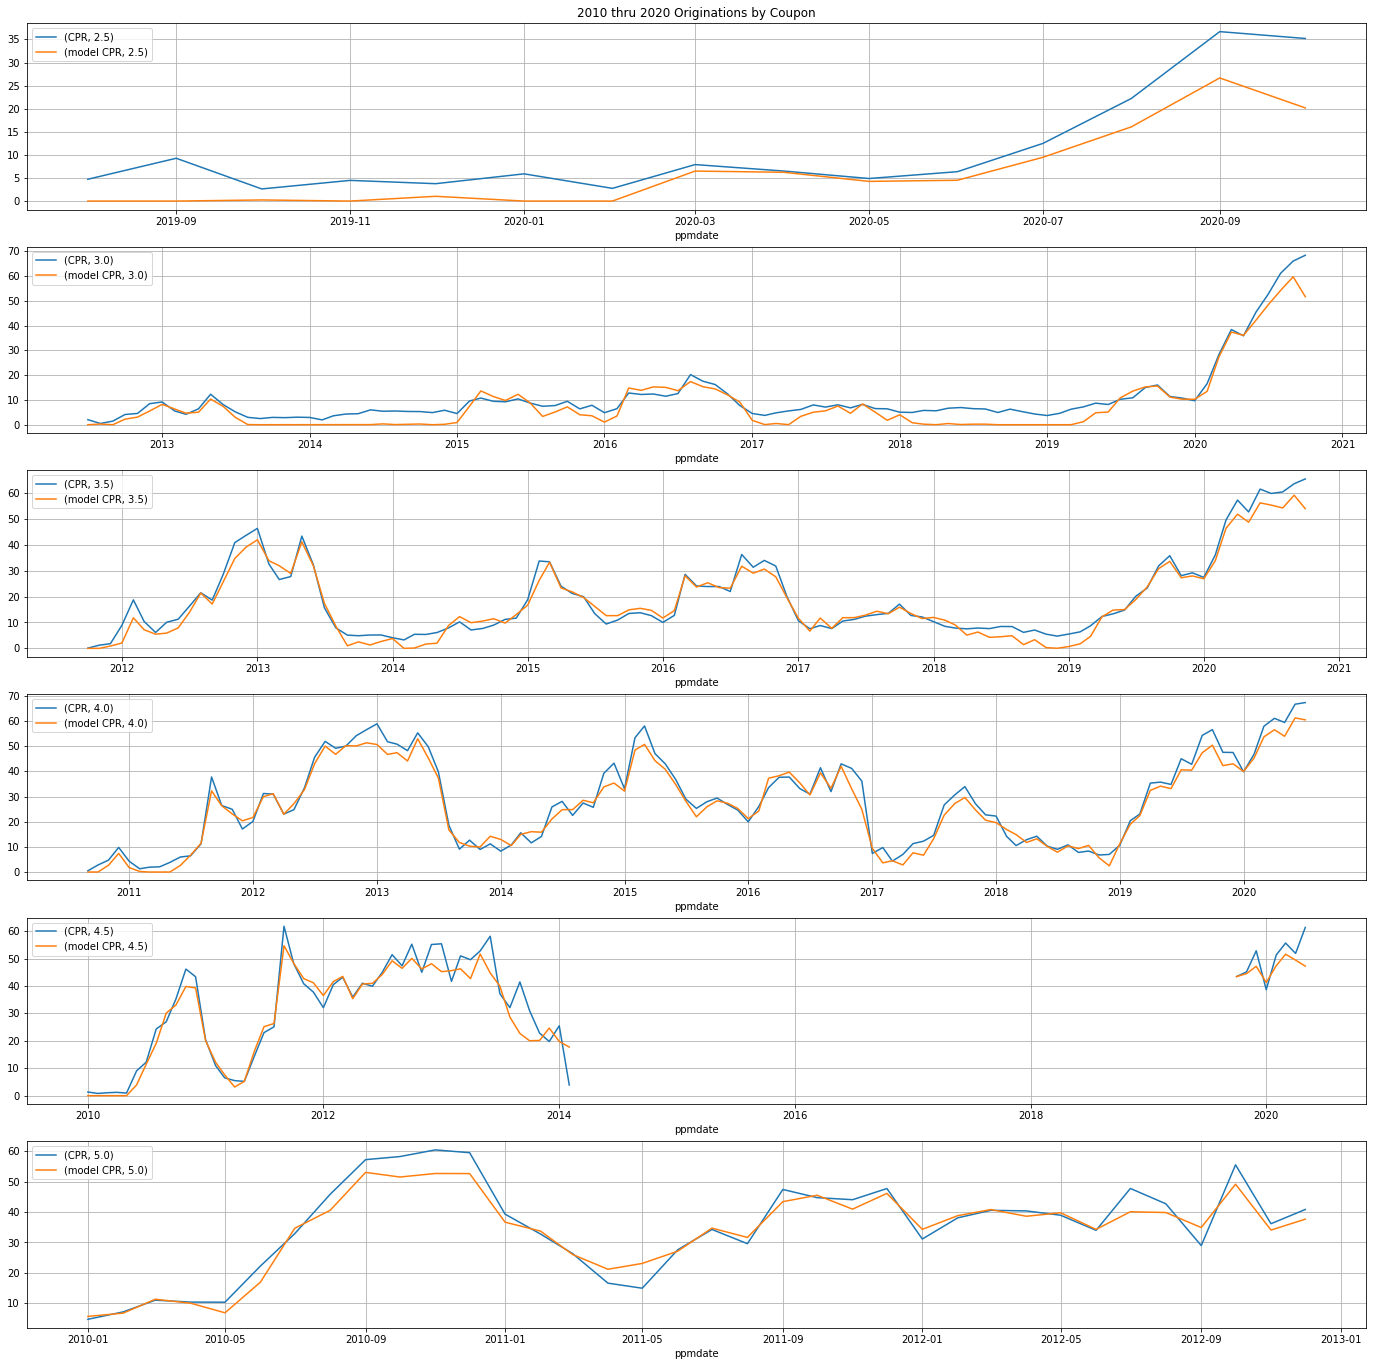

In [370]:
valReport(df[df['cnloans']>=cnloans],graphTitle='2010 thru 2020 Originations by Coupon',fsize=(24,24))

In [371]:
np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & (df['asofdate']<data_cutoff)],col_name='(Train) 2010 - 2020 Vintages NN RMSE (CPR)'),2)

,(Train) 2010 - 2020 Vintages NN RMSE (CPR)
Coupon,
2.5,4.91
3.0,3.54
3.5,3.00
4.0,3.46
4.5,5.43
5.0,3.88


In [372]:
np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & (df['asofdate']>=data_cutoff)],col_name='(Test) 2010 - 2020 Vintages NN RMSE (CPR)'),2)

,(Test) 2010 - 2020 Vintages NN RMSE (CPR)
Coupon,
2.5,15.03
3.0,16.71
3.5,11.49


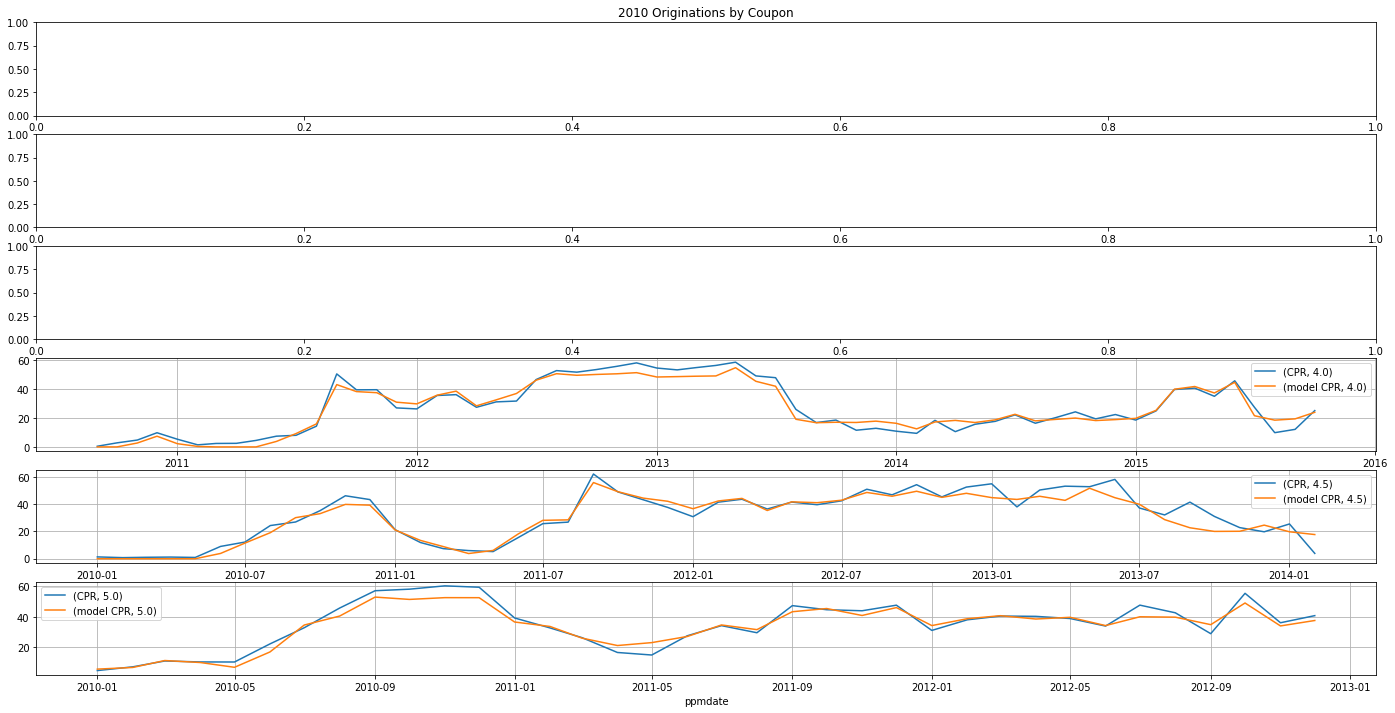

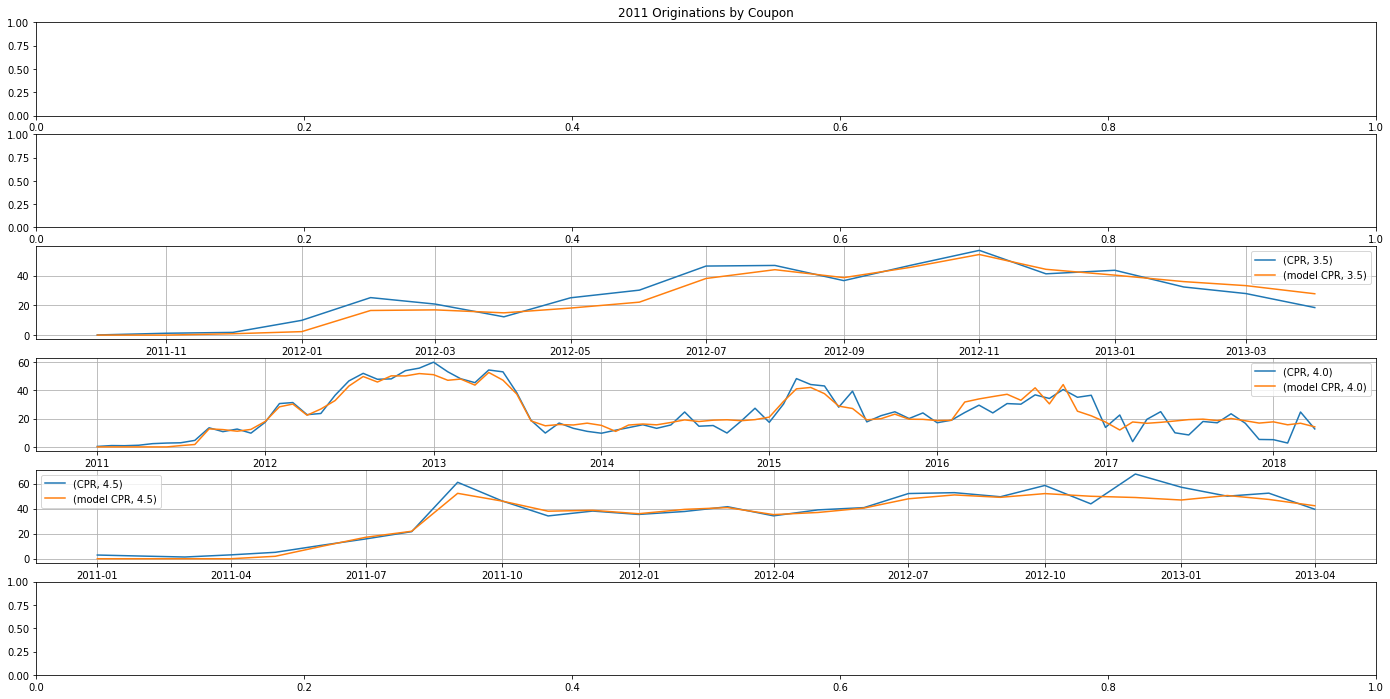

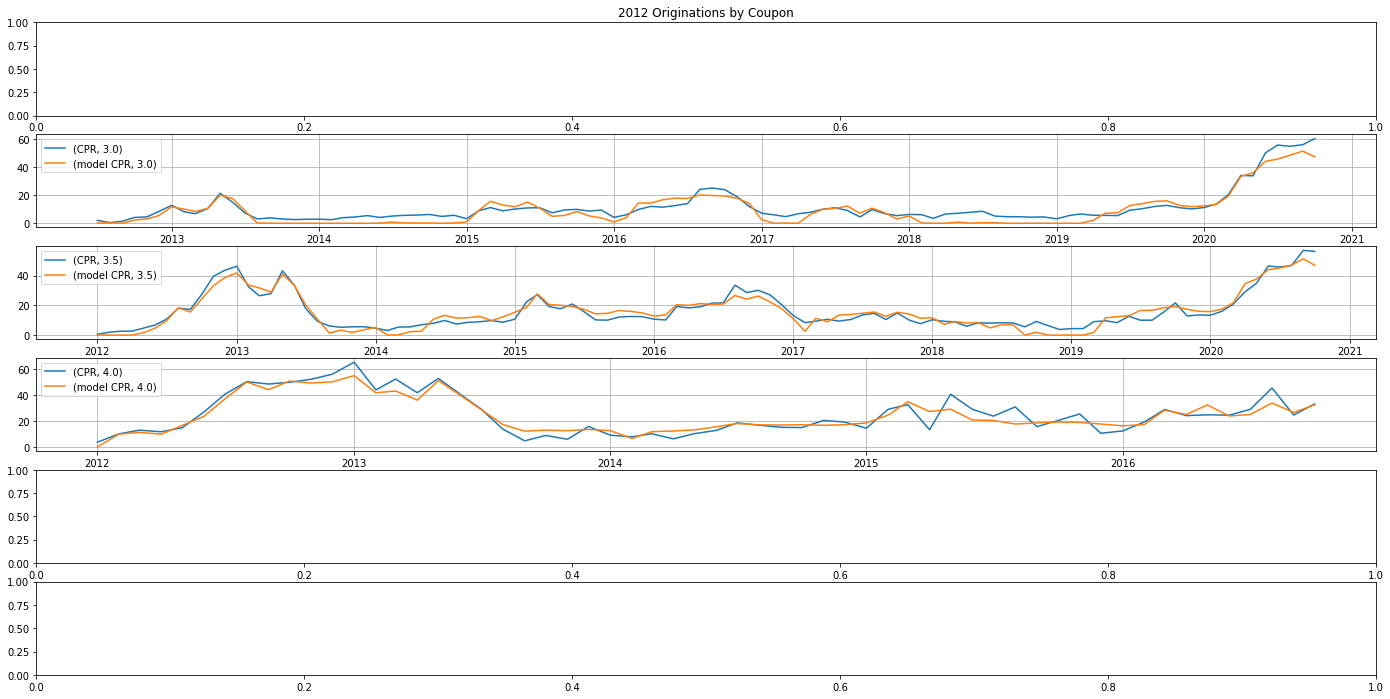

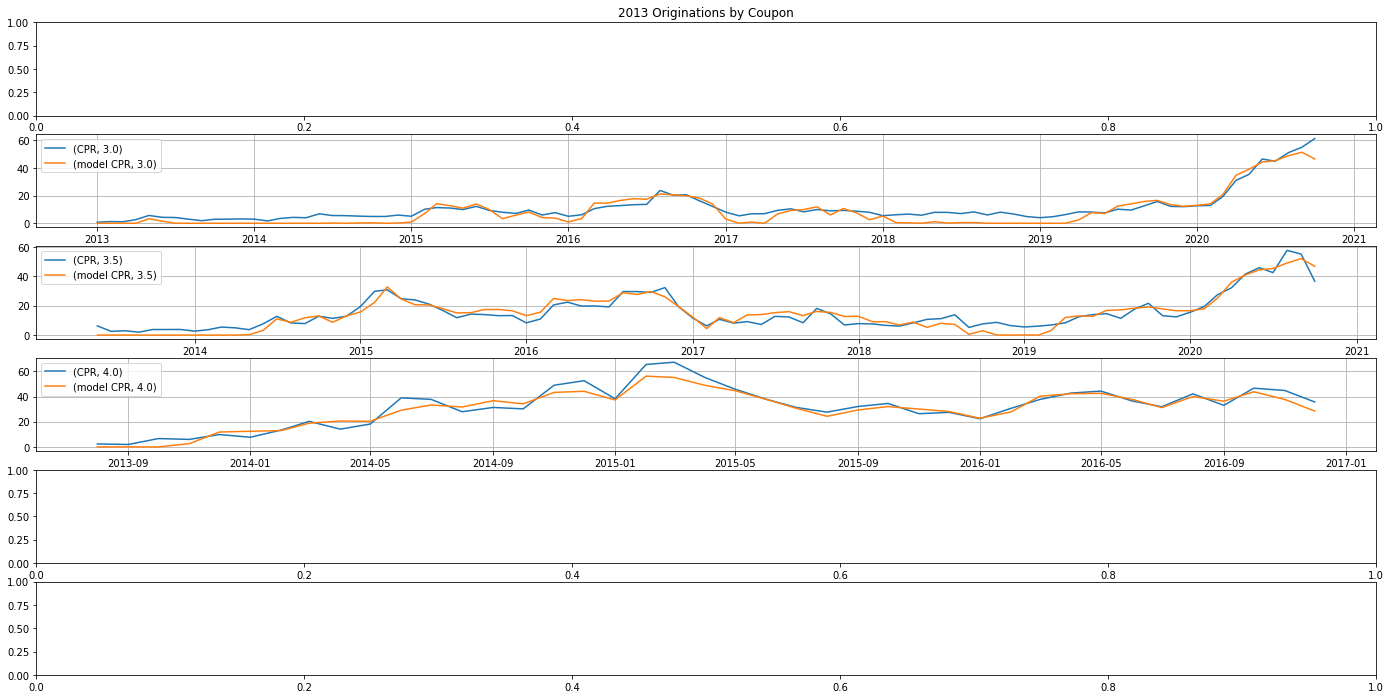

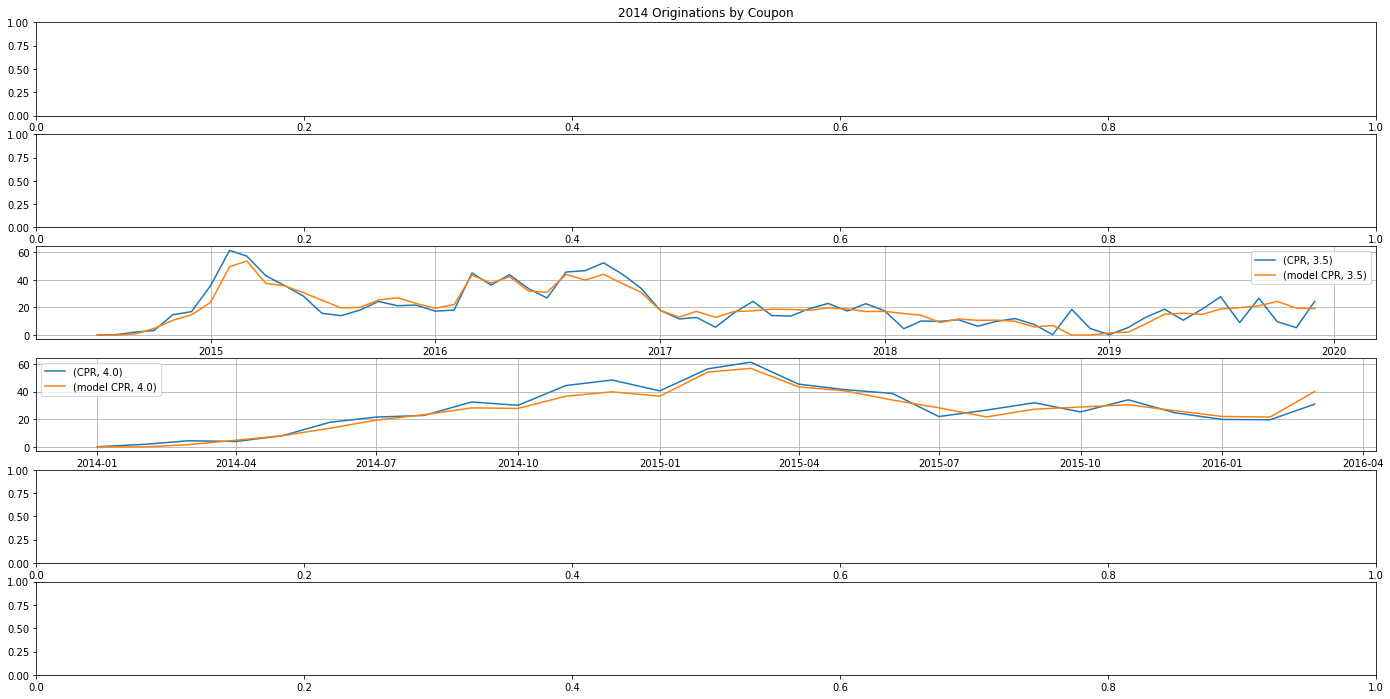

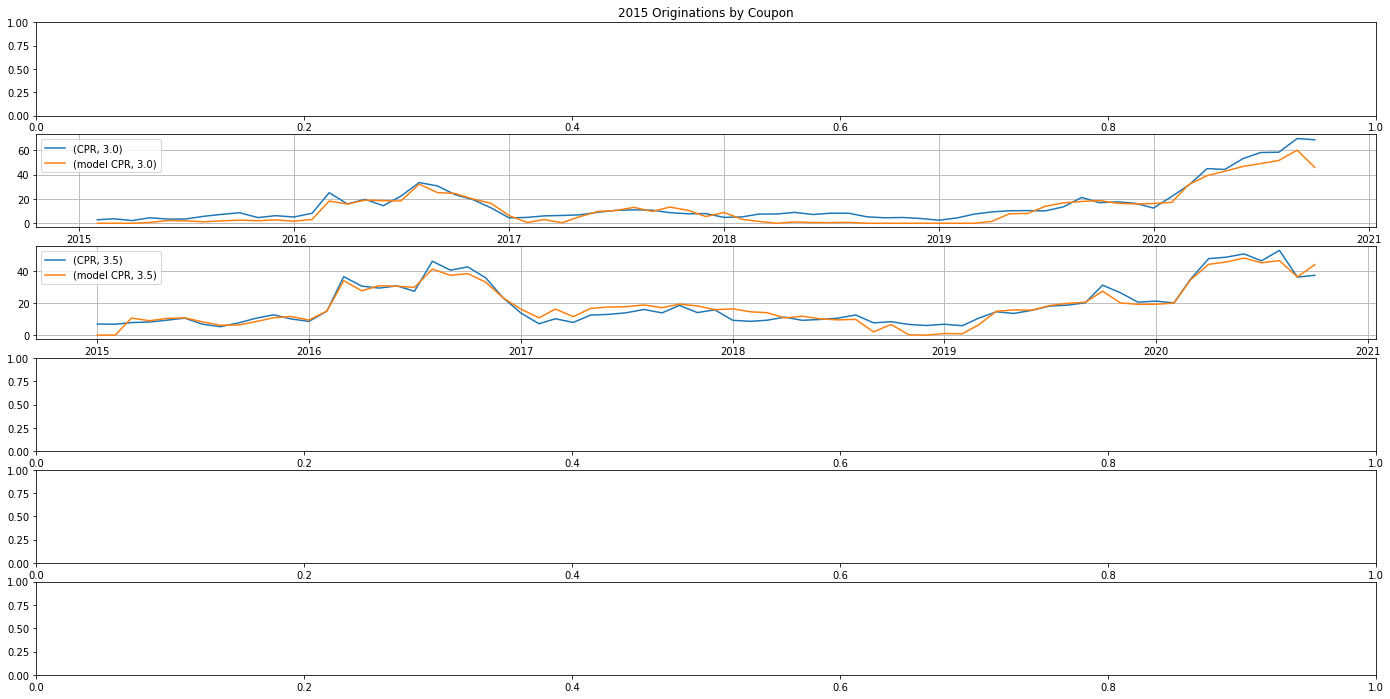

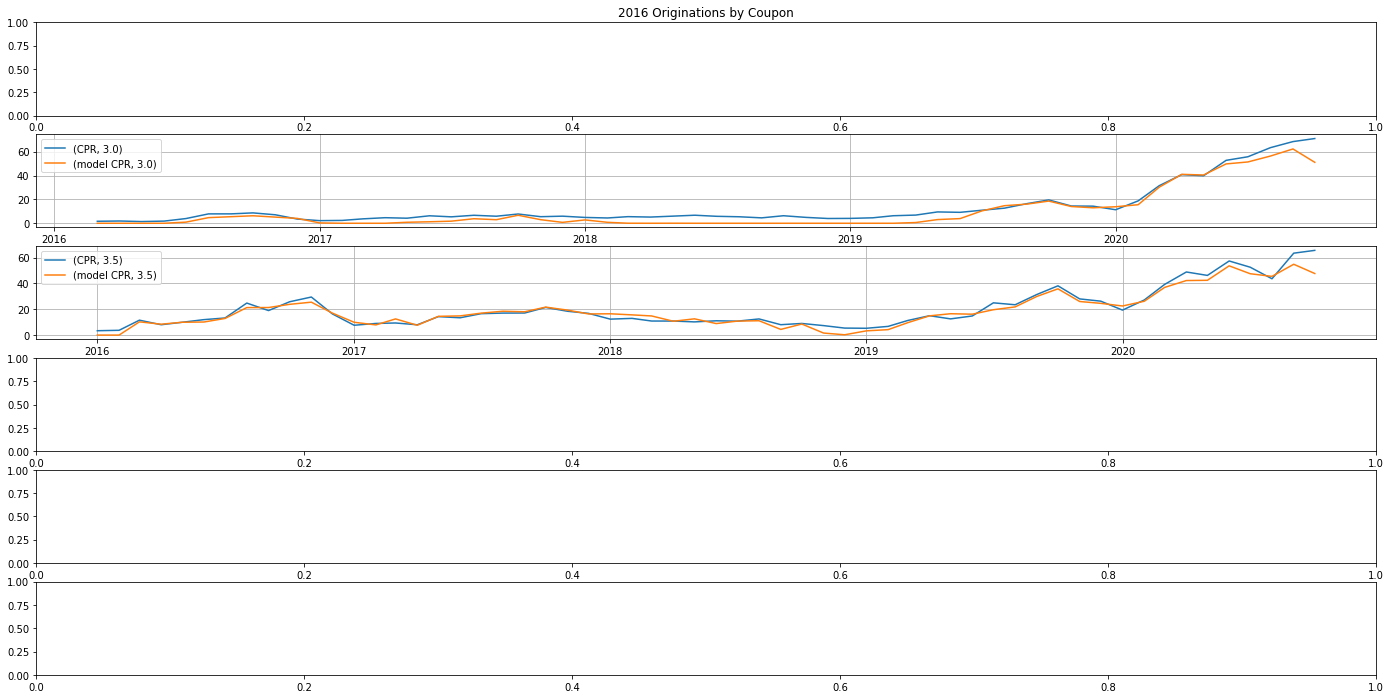

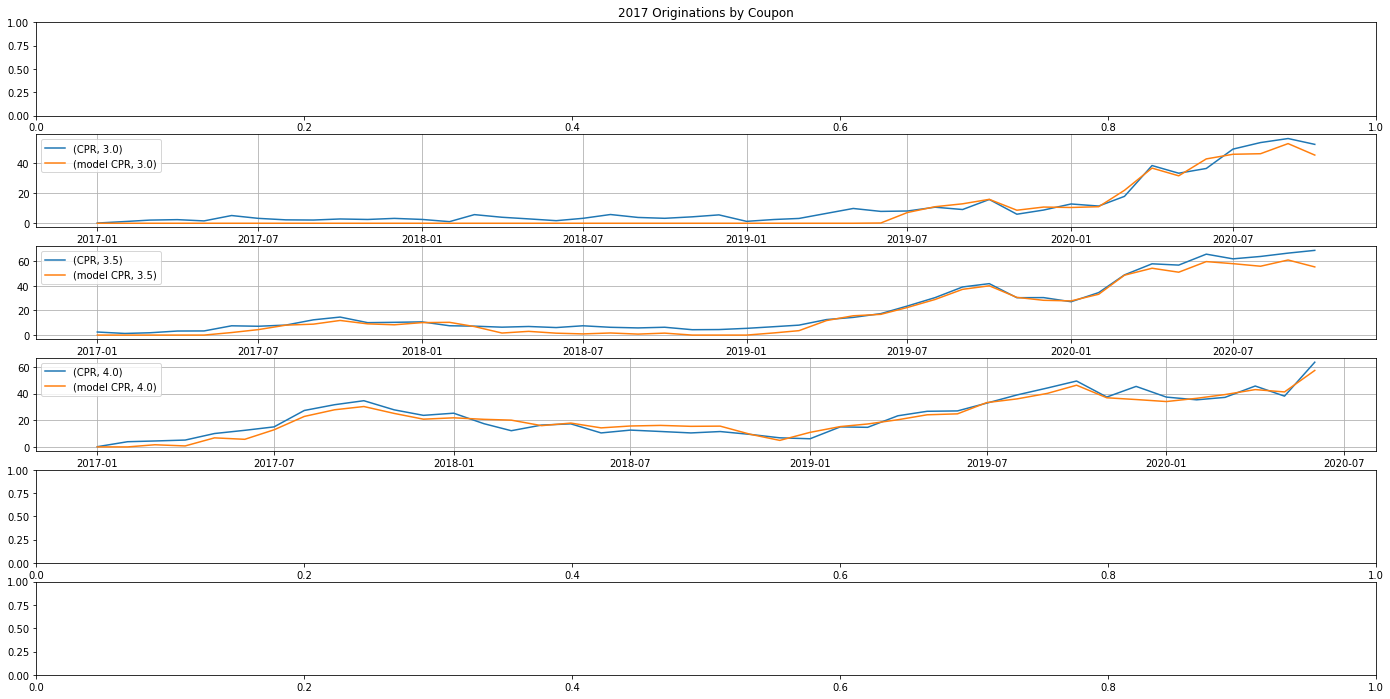

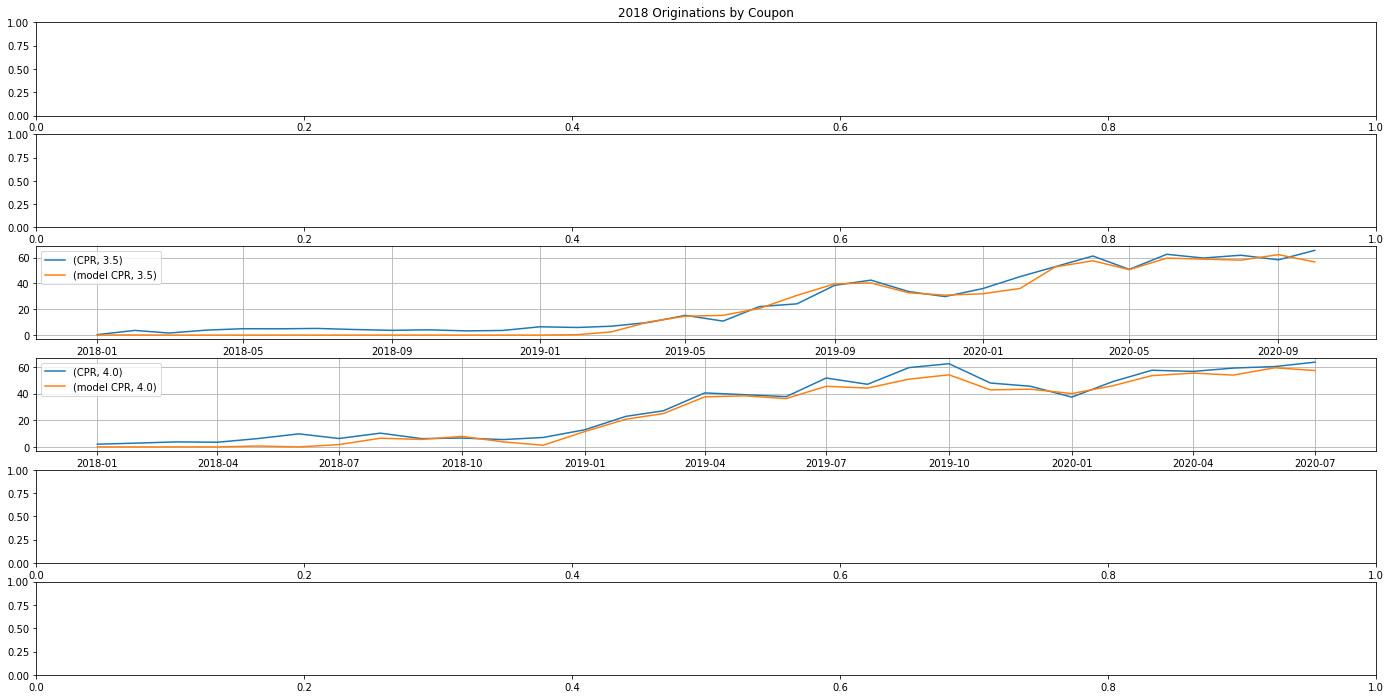

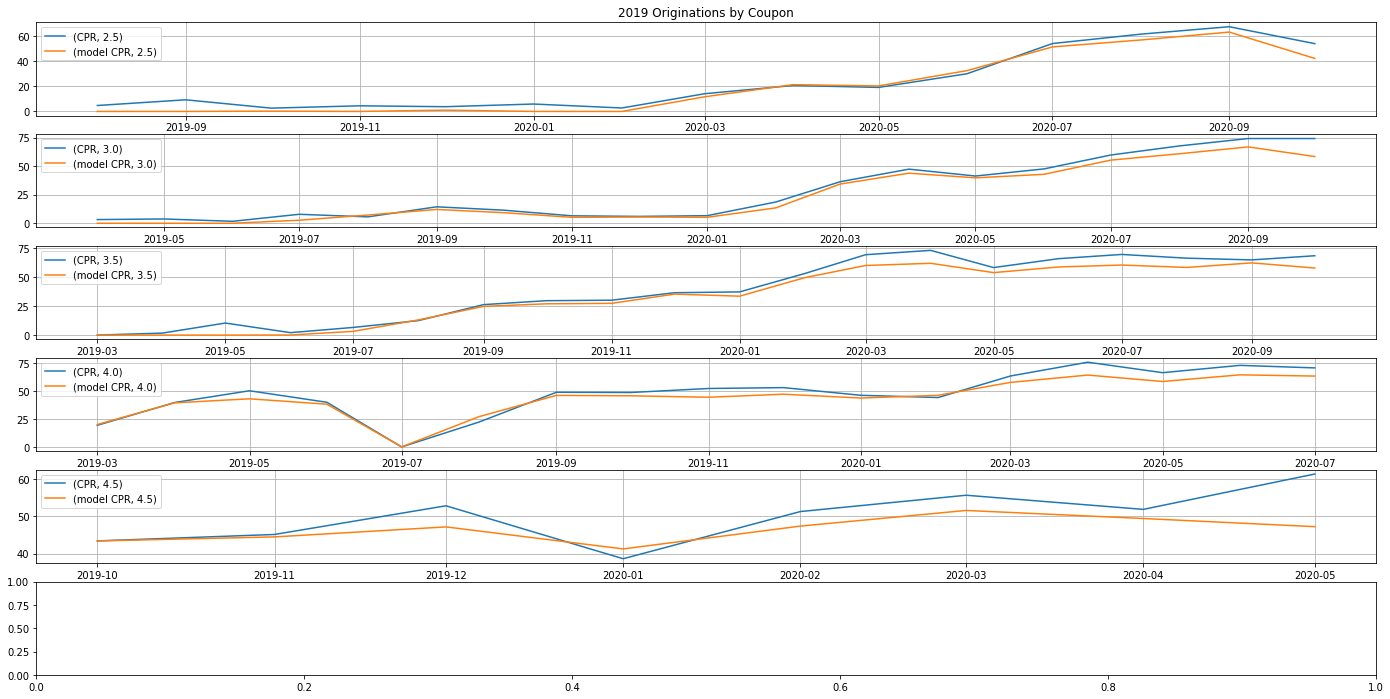

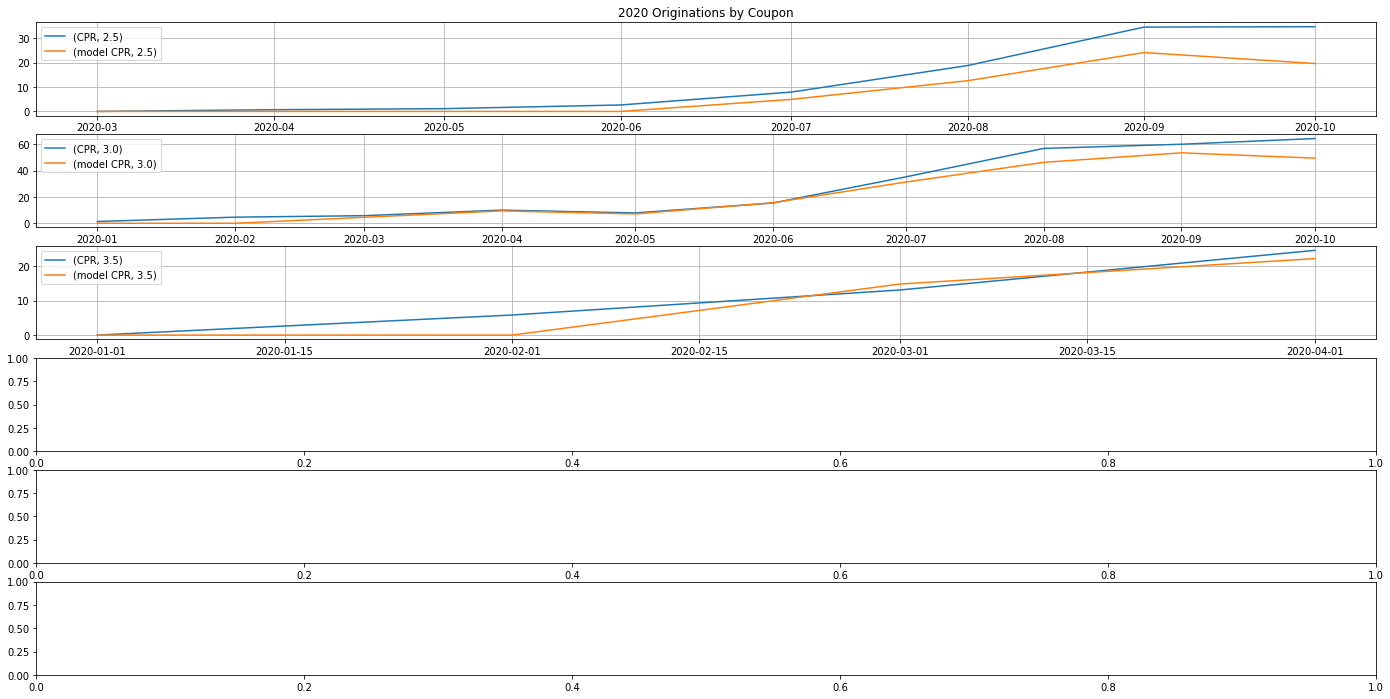

In [373]:
for vintage in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]:

    valReport(df[(df['cnloans']>=cnloans) & (df['Vintage'] == vintage)],graphTitle=f'{vintage} Originations by Coupon',fsize=(24,12))

In [374]:
for vintage in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]:

    print(np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & (df['asofdate']>=data_cutoff) & (df['Vintage'] == vintage)],col_name=f'{vintage} NN RMSE (CPR)'),2))
    print('\n')

Empty DataFrame
Columns: [2010 NN RMSE (CPR)]
Index: []


Empty DataFrame
Columns: [2011 NN RMSE (CPR)]
Index: []


        2012 NN RMSE (CPR)
Coupon                    
3.0                  13.07
3.5                   9.36


        2013 NN RMSE (CPR)
Coupon                    
3.0                  14.77
3.5                  10.20


Empty DataFrame
Columns: [2014 NN RMSE (CPR)]
Index: []


        2015 NN RMSE (CPR)
Coupon                    
3.0                  22.73
3.5                   6.64


        2016 NN RMSE (CPR)
Coupon                    
3.0                  19.93
3.5                  17.94


        2017 NN RMSE (CPR)
Coupon                    
3.0                   7.12
3.5                  13.45


        2018 NN RMSE (CPR)
Coupon                    
3.5                   8.97


        2019 NN RMSE (CPR)
Coupon                    
2.5                  11.78
3.0                  15.78
3.5                  10.63


        2020 NN RMSE (CPR)
Coupon                    
2.

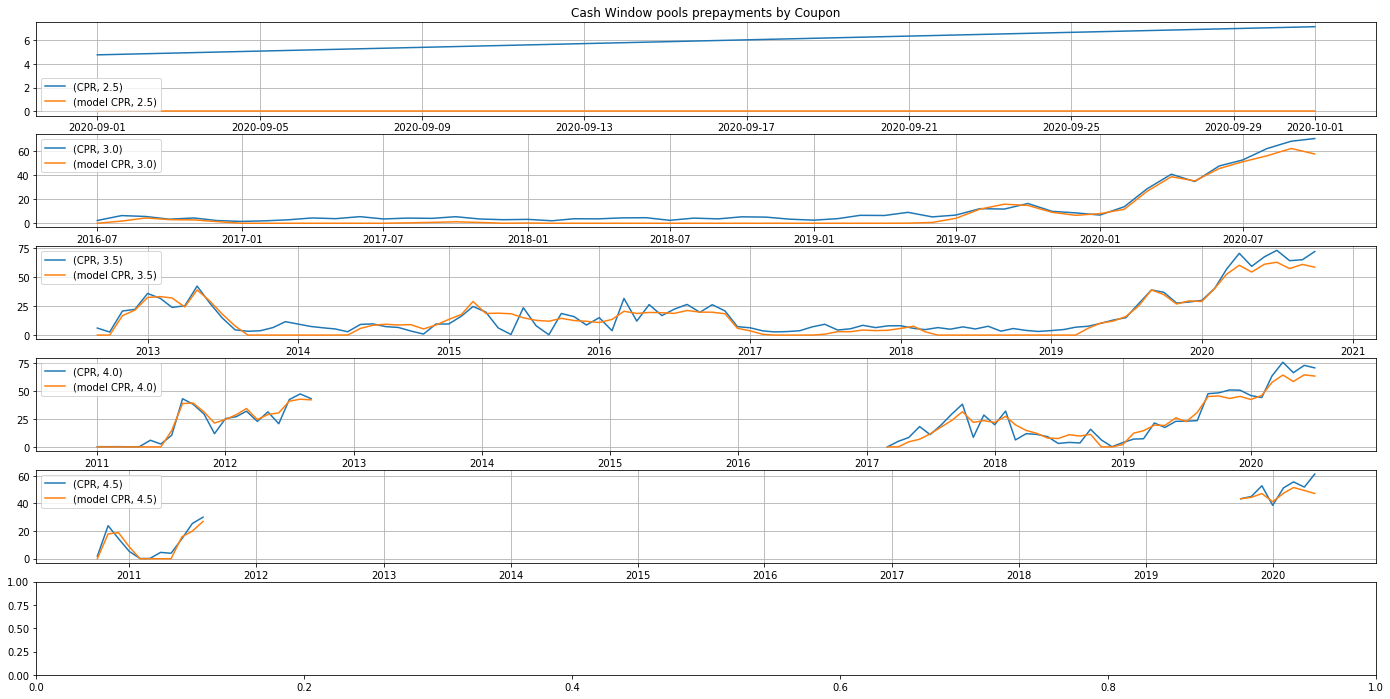

In [375]:
valReport(df[(df['cnloans']>=cnloans) & (df['%CashWindow'] == 100) & (df['Vintage'] > 2009)],graphTitle='Cash Window pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5)

In [376]:
np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & (df['asofdate']>=data_cutoff) & (df['%CashWindow'] == 100)],col_name='Cash Window - NN RMSE (CPR)'),2)

,Cash Window - NN RMSE (CPR)
Coupon,
2.5,7.12
3.0,12.88
3.5,13.54


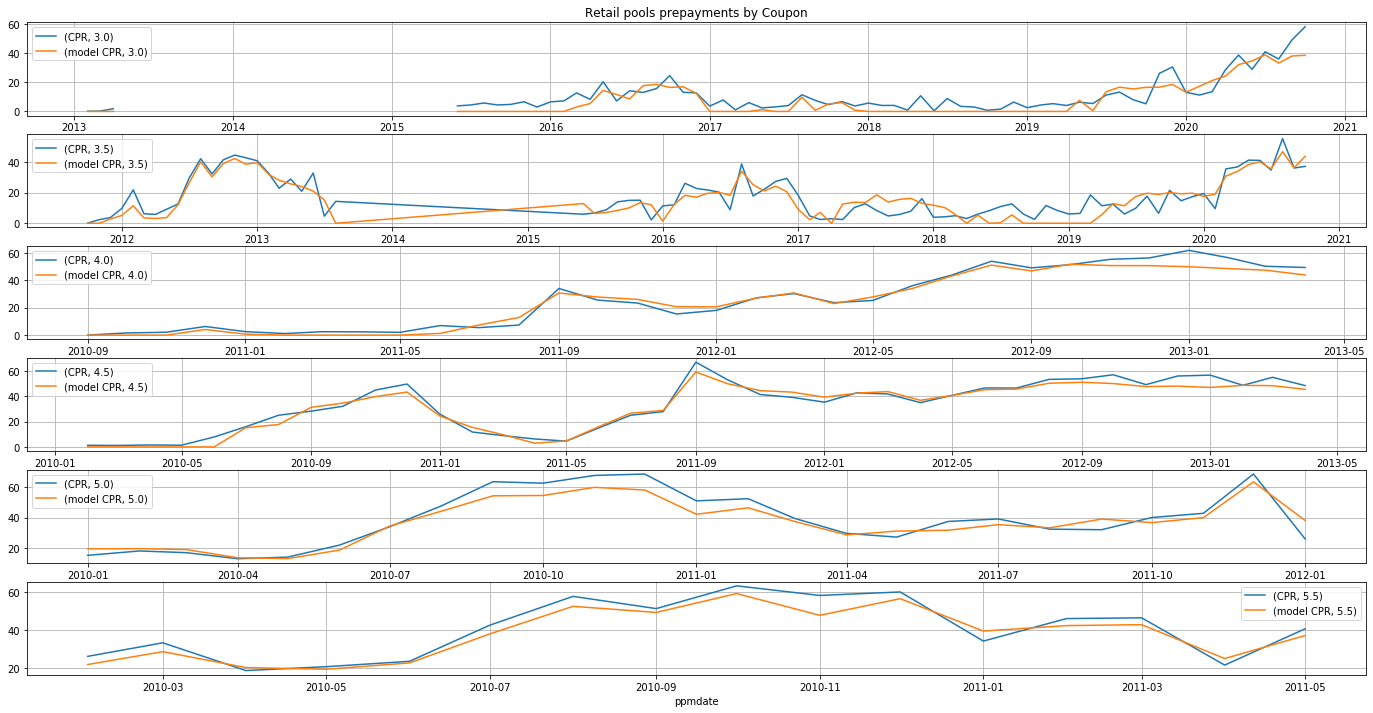

In [377]:
valReport(df[(df['cnloans']>=cnloans) & (df['PctChannel_Retail'] > 99) & (df['Vintage'] > 2009)],graphTitle='Retail pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

In [378]:
np.round(rmse_by_coupon(df[(df['cnloans']>=cnloans) & (df['asofdate']>=data_cutoff) & (df['PctChannel_Retail'] > 99)],col_name='Retail - NN RMSE (CPR)'),2)

,Retail - NN RMSE (CPR)
Coupon,
3.0,19.75
3.5,6.64


### Save the neural network prepayment model in .h5 format

In [331]:
from tensorflow.keras.models import load_model

In [380]:
model_name = 'jumbo_30yr_fixed.h5'

#### Uncomment the line below if you would like to save

In [381]:
model.save(model_name)

#### Uncomment the line below if you would like to load the model saved in Git repository

In [334]:
# model = load_model('nn-ppm-from-csv.h5')

#### Section below is still under development

In [335]:
# import kerastuner as kt 

In [336]:
# def model_builder(hp):

#     model = Sequential()
    
#     #input layer / first hidden layer

#     first_layer_neurons      = hp.Int('layer_1_units', min_value=32, max_value = 1024, step = 32)
#     first_layer_dropout_rate = hp.Float('layer_1_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(first_layer_neurons, input_dim=X_train.shape[1], activation='relu'))
#     model.add(Dropout(first_layer_dropout_rate))

#     # 2nd layer
#     second_layer_neurons      = hp.Int('layer_2_units', min_value=128, max_value = 512, step = 32)
#     second_layer_dropout_rate = hp.Float('layer_2_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(second_layer_neurons, activation='relu'))
#     model.add(Dropout(second_layer_dropout_rate))

#     # 3rd layer
#     third_layer_neurons      = hp.Int('layer_3_units', min_value=64, max_value = 256, step = 32)
#     third_layer_dropout_rate = hp.Float('layer_3_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(third_layer_neurons, activation='relu'))
#     model.add(Dropout(third_layer_dropout_rate))

#     # 4th layer
#     forth_layer_neurons      = hp.Int('layer_4_units', min_value=32, max_value = 128, step = 32)
#     forth_layer_dropout_rate = hp.Float('layer_4_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(forth_layer_neurons, activation='relu'))
#     model.add(Dropout(forth_layer_dropout_rate))

#     #output layer
#     model.add(Dense(1, activation='relu')) # relu activation is perfect here, because SMM cannot be negative

#     model.compile(optimizer='adam', loss='mse')
#     #model.compile(optimizer='rmsprop', loss='mse')    

#     return model

In [337]:
# tuner = kt.Hyperband(model_builder,
#                      objective='val_loss',
#                      max_epochs=10,
#                      hyperband_iterations=2,
#                      directory=os.path.normpath('C:/'),
#                      project_name='nn_ppm_model-' + dt.datetime.now().strftime('%Y-%M-%d-%H-%M-%S'))

In [338]:
# tuner.search(x=X_train,
#              y=y_train,
#              validation_data=(X_test,y_test),
#              batch_size=1024,
#              epochs=10)

In [339]:
# best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [340]:
# model = tuner.hypermodel.build(best_hps)

In [341]:
# model.summary()

In [342]:
# tuner.results_summary()